In [1]:
%retina

UsageError: Line magic function `%retina` not found.


In [1]:
pwd

'/private/home/jeanremi/project/jrr/code/meg_experiment'

In [10]:
%matplotlib inline

import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
from scipy.stats import wilcoxon
import seaborn as sns
import pandas as pd
import mne

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scipy.stats import ttest_1samp, wilcoxon

from common import log_files, data_path, read_log, get_log_times
from base import fetch_data

In [11]:
import mne
import numpy as np
import os.path as op
from scipy.linalg import svd
from scipy.stats import pearsonr

from sklearn.base import clone
from sklearn.preprocessing import scale
from sklearn.model_selection import ShuffleSplit

def ridge_cv(X, Y, alphas, independent_alphas=False, Uv=None):
    """ Similar to sklearn RidgeCV but
   (1) can optimize a different alpha for each column of Y
   (2) return leave-one-out Y_hat
   """
    if isinstance(alphas, (float, int)):
        alphas = np.array([alphas, ], np.float64)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, n_x = X.shape
    n, n_y = Y.shape
    # Decompose X
    if Uv is None:
        U, s, _ = svd(X, full_matrices=0)
        v = s**2
    else:
        U, v = Uv
    UY = U.T @ Y

    # For each alpha, solve leave-one-out error coefs
    cv_duals = np.zeros((len(alphas), n, n_y))
    cv_errors = np.zeros((len(alphas), n, n_y))
    for alpha_idx, alpha in enumerate(alphas):
        # Solve
        w = ((v + alpha) ** -1) - alpha ** -1
        c = U @ np.diag(w) @ UY + alpha ** -1 * Y
        cv_duals[alpha_idx] = c

        # compute diagonal of the matrix: dot(Q, dot(diag(v_prime), Q^T))
        G_diag = (w * U ** 2).sum(axis=-1) + alpha ** -1
        error = c / G_diag[:, np.newaxis]
        cv_errors[alpha_idx] = error

    # identify best alpha for each column of Y independently
    if independent_alphas:
        best_alphas = (cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = np.transpose([cv_duals[b, :, i]
                              for i, b in enumerate(best_alphas)])
        cv_errors = np.transpose([cv_errors[b, :, i]
                                  for i, b in enumerate(best_alphas)])
    else:
        _cv_errors = cv_errors.reshape(len(alphas), -1)
        best_alphas = (_cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = cv_duals[best_alphas]
        cv_errors = cv_errors[best_alphas]

    coefs = duals.T @ X
    Y_hat = Y - cv_errors
    return coefs, best_alphas, Y_hat


def fit_knockout(X, Y, alphas, independent_alphas=False,
                 pairwise=False):
    """Fit model using all but knockout X features"""
    n_x, n_y = X.shape[1], Y.shape[1]

    K = list()
    for xi in np.arange(n_x)[:, None]:
        not_xi = np.setdiff1d(np.arange(n_x), xi)

        # When X and Y are matched in dimension, we can speed things
        # up by only computing the regression pairwise, as the other
        # columns won't be analyzed
        if pairwise:
            y_sel = np.asarray(xi)
        else:
            y_sel = np.arange(Y.shape[1])
        x_sel = np.array(not_xi)

        K_ = np.zeros((n_y, n_x))
        K_[y_sel[:, None], x_sel] = ridge_cv(X[:, x_sel], Y[:, y_sel],
                                             alphas, independent_alphas)[0]
        K.append(K_)
    return K


def r_score(Y_true, Y_pred):
    """column-wise correlation coefficients"""
    if Y_true.ndim == 1:
        Y_true = Y_true[:, None]
    if Y_pred.ndim == 1:
        Y_pred = Y_pred[:, None]
    R = np.zeros(Y_true.shape[1])
    for idx, (y_true, y_pred) in enumerate(zip(Y_true.T, Y_pred.T)):
        R[idx] = pearsonr(y_true, y_pred)[0]
    return R


class B2B():
    def __init__(self, alphas=np.logspace(-4, 4, 20),
                 independent_alphas=True, ensemble=None):
        self.alphas = alphas
        self.independent_alphas = independent_alphas
        self.ensemble = ensemble

    def fit(self, X, Y):
        
        self.G_ = list()
        self.H_ = list()
        self.Ks_ = list()
        
        # Prepare ensembling
        if self.ensemble is None:
            ensemble = [(range(len(X)), range(len(X))),]
        else:
            if isinstance(self.ensemble, int):
                ensemble = ShuffleSplit(self.ensemble)
            else:
                ensemble = self.ensemble
            ensemble = [split for split in ensemble.split(X)]
            
        # Ensembling loop
        for train, test in ensemble:
            
            # Fit decoder
            G, G_alpha, YG = ridge_cv(Y[train], X[train], 
                                      self.alphas, 
                                      self.independent_alphas)
            self.G_.append(G)
            
            if len(X[train]) != len(X):
                YG = Y @ G.T
            
            # Fit encoder
            H, H_alpha, _ = ridge_cv(X[test], YG[test],
                                     self.alphas,
                                     self.independent_alphas)
            self.H_.append(H)
            
            # Fit knock-out encoders
            Ks = fit_knockout(X, YG, 
                              self.alphas,
                              self.independent_alphas, True)
            self.Ks_.append(Ks)

        # Aggregate ensembling
        self.G_ = np.mean(self.G_, 0)
        self.H_ = np.mean(self.H_, 0)
        self.Ks_ = np.mean(self.Ks_, 0)
        
        self.E_ = np.diag(self.H_)
        
        return self

    def score(self, X, Y):
        # Transform with decoder
        YG = Y @ self.G_.T
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column X
        return r_score(YG, XH)

    def score_knockout(self, X, Y):
        # Transform with decoder
        YG = Y @ self.G_.T

        # For each knock-out, compute R score
        K_scores = list()
        for xi, K in enumerate(self.Ks_):
            # Knocked-out encoder predictions
            XK = X @ K.T
            # R score for each relevant dimensions of X
            K_scores.append(r_score(YG[:, xi], XK[:, xi])[0])

        return np.array(K_scores)


class Forward():
    def __init__(self, alphas=np.logspace(-4, 4, 20), independent_alphas=True):
        self.alphas = alphas
        self.independent_alphas = independent_alphas

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(X, Y, self.alphas,
                                       self.independent_alphas)
        # Fit knock-out encoders
        self.Ks_ = fit_knockout(X, Y, self.alphas,
                                self.independent_alphas, False)

        self.E_ = np.sum(self.H_**2, 0)
        return self

    def score(self, X, Y):
        # Make standard and knocked-out encoders predictions
        XH = X @ self.H_.T
        # Compute R for each column of Y
        return r_score(Y, XH)

    def score_knockout(self, X, Y):
        K_scores = list()
        for xi, K in enumerate(self.Ks_):
            # Knocked-out encoder predictions
            XK = X @ K.T
            # R score for each relevant dimensions of X
            K_score = r_score(Y, XK)
            # Difference between standard and knocked-out scores
            K_scores.append(K_score)

        return np.array(K_scores)
    
    def predict(self, X):
        return X @ self.H_.T


class Backward():
    def __init__(self, alphas=np.logspace(-4, 4, 20), independent_alphas=True):
        self.alphas = alphas
        self.independent_alphas = independent_alphas

    def fit(self, X, Y):
        # Fit encoder
        self.H_, H_alpha, _ = ridge_cv(Y, X, self.alphas,
                                       self.independent_alphas)

        self.E_ = np.sum(self.H_**2, 1)
        return self

    def score(self, X, Y):
        # Make standard and knocked-out encoders predictions
        YH = Y @ self.H_.T
        # Compute R for each column of Y
        return r_score(X, YH)

    def score_knockout(self, X, Y):
        return 0
    
    
    def predidct(self, X):
        return 0


def cross_decomp_transform(model, X, Y):
    
        X = X - model.x_mean_
        X /= model.x_std_
        X = X @ model.x_rotations_
        
        Y = Y - model.y_mean_
        Y /= model.y_std_
        Y = Y @ model.y_rotations_
        
        return X, Y


class CrossDecomp():
    """fit X => Y"""
    def __init__(self, model):
        self.model = model

    def fit(self, X, Y):
        # fit CCA
        self.model.fit(X, Y)
        
        if hasattr(self.model, 'estimator'):
            self.model_ = self.model.estimator.fit(X, Y)
        else:
            self.model_ = self.model

        # fit_knockout
        n_x = X.shape[1]
        self.Ks_ = list()
        for xi in np.arange(n_x):
            
            knockout = np.diag(np.ones(n_x))
            knockout[xi] = 0
            self.Ks_.append(clone(self.model_).fit(X @ knockout, Y))
        
        self.E_ = np.sum(self.model_.x_rotations_**2, 1)
        return self

    def score(self, X, Y):
        X, Y = cross_decomp_transform(self.model_, X, Y)
        R_score = r_score(X, Y)
        return R_score
   
    def score_knockout(self, X, Y):

        n_x = X.shape[1]
        
        K_scores = list()
        for xi, K in enumerate(self.Ks_):
       
            knockout = np.diag(np.ones(n_x))
            knockout[xi] = 0
            
            Xk, Yk = cross_decomp_transform(K, X @ knockout, Y)

            K_scores.append(r_score(Xk, Yk))
        
        return np.array(K_scores)
    
    def predict(self, X):
        return self.model_.predict(X)

In [12]:
log_files = log_files.query('task=="visual"')

# Run B2B and all

In [16]:
from sklearn.cross_decomposition import CCA, PLSRegression

In [53]:
def run(subject, model_name, overwrite=False, folder='jrr_neurips'):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', folder, '%s-preproc.pkl' % subject.subject)
    save_path = op.join(data_path, '..', folder, '%s-%s.pkl' % (subject.subject, model_name))
    
    # Don't compute if already exists
    if op.isfile(save_path) and not overwrite:
        with open(save_path, 'rb') as f:
            return pickle.load(f)
    
    # Load and preprocess data
    if op.isfile(preproc_path):
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
    else:
        meg, times, features, names, words = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names, words], f)
    
    cv = KFold(5, shuffle=True)    
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape
    
    
    # Prepare model
    max_comp = min(meg.shape[1], n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)

    grid = dict(n_components=np.unique(np.floor(np.linspace(1, n_features, 10)).astype(int)))
    models = dict(B2B=B2B(),
                  B2B_ensemble=B2B(ensemble=20),
                  Backward=Backward(),
                  Forward=Forward(),
                  
                  CCA=CrossDecomp(GridSearchCV(CCA(), grid, cv=5)),
                  PLS=CrossDecomp(GridSearchCV(PLSRegression(), grid, cv=5)),
                  
                  CCA1=CrossDecomp(CCA(1)),
                  CCA2=CrossDecomp(CCA(2)),
                  CCA3=CrossDecomp(CCA(3)),
                  CCA4=CrossDecomp(CCA(4)),
                  CCA6=CrossDecomp(CCA(6)),
                  
                  PLS1=CrossDecomp(PLSRegression(1)),
                  PLS2=CrossDecomp(PLSRegression(2)),
                  PLS3=CrossDecomp(PLSRegression(3)),
                  PLS4=CrossDecomp(PLSRegression(4)),
                  PLS6=CrossDecomp(PLSRegression(6)),
                 )
    model = models[model_name]
    print(subject.subject, model_name)

    # Loop across times
    scoring = 'r'
    multioutput = 'uniform_average'
    
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
            
            # Fit model
            model.fit(X[train], Y[train])
            
            # Compute standard scores
            H = model.score(X[test], Y[test])
            
            if t == 0 and split == 0:
                H_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))
                K_r = np.zeros((cv.n_splits, n_times, n_features, *H.shape))
            
            H_r[split, t] = H
            
            # Compute knock out scores
            K_r[split, t] = model.score_knockout(X[test], Y[test])

    # Mean scores across splits
    H_r = H_r.mean(0)
    K_r = K_r.mean(0)
    
    # Save
    print('save')
    with open(save_path, 'wb') as f:
        pickle.dump([H_r, K_r], f)

    print(time.time() - start)
    
    return H_r, K_r

In [54]:
run(log_files.iloc[0], 'CCA', overwrite=True)

1573513157.9831529










  0%|          | 0/67 [00:00<?, ?it/s]

1001 CCA










  1%|▏         | 1/67 [00:53<59:20, 53.94s/it]







  3%|▎         | 2/67 [01:42<56:49, 52.45s/it]







  4%|▍         | 3/67 [02:37<56:44, 53.20s/it]

KeyboardInterrupt: 

In [24]:
import warnings
warnings.simplefilter("ignore")

In [ ]:
run(log_files.iloc[0], 'PLS')

In [30]:
folder = 'jrr_neurips'
preproc_path = op.join(data_path, '..', folder,
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

In [32]:
log_path = op.join(data_path, '..', 'jrr_neurips', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=140, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=10)

jobs = list()
models = (
    'B2B', 
    'Backward',
    'Forward',
    'CCA',
    'PLS',
)
folder = 'jrr_neurips'

for subject in trange(len(log_files)):
    for model_name in models:
        subject_info = log_files.iloc[subject]
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject_info.subject, model_name))
        if op.isfile(save_path):
            continue
        jobs.append([subject_info, model_name, True, folder])
jobs = executor.map_array(run, *zip(*jobs))








  0%|          | 0/100 [00:00<?, ?it/s]






 29%|██▉       | 29/100 [00:00<00:00, 287.45it/s]






 54%|█████▍    | 54/100 [00:00<00:00, 273.93it/s]






 85%|████████▌ | 85/100 [00:00<00:00, 282.15it/s]






100%|██████████| 100/100 [00:00<00:00, 278.15it/s]

In [36]:
jobs

[SlurmJob<job_id=20063066_0, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_1, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_2, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_3, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_4, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_5, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_6, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_7, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_8, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_9, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_10, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_11, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_12, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_13, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_14, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_15, task_id=0, state="COMPLETED">,
 SlurmJob<job_id=20063066_16, task

In [37]:
times = np.linspace(-.100, 1., 67)

In [38]:
def get_results(model_name, folder='jrr_neurips'):
    
    H_r, K_r = list(), list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject, model_name))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                dat = pickle.load(f)
            
            if dat[0].shape[1] != 4:
                print(save_path)
                continue
            H_r.append(dat[0])
            K_r.append(dat[1])

    if model_name == 'Forward':
        H_r = [h[:, :, :301] for h in H_r]
        K_r = [h[:, :, :301] for h in K_r]
    H_r, K_r = np.array(H_r), np.array(K_r)
    return H_r, K_r

In [46]:
models = [
          #'Backward', 
          'Forward',
          'PLS',
          'CCA',
          'B2B', 
]
folder = 'jrr_neurips'

features = ('Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable')

data = list()
for subject in range(len(log_files)):

    subject = log_files.loc[subject, 'subject']
    for model in models:
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s.pkl' % (subject, model))
        if op.isfile(save_path):
            with open(save_path, 'rb') as f:
                H_r, K_r = pickle.load(f)
                if H_r.shape[1] != 4:
                    continue
                H_r = H_r
                K_r = K_r
            
            for effect_idx, effect in enumerate(features):

                t = .150 if effect == 'word length' else .400
                t = np.where(times>=t)[0][0]
                t = np.where((times>=0.) * (times<=1.))[0]
                
                score = np.mean(H_r[t, effect_idx] - K_r[t, effect_idx], 0)
                
                if model == 'CCA':
                    0/0
                
                if model in ('B2B', 'B2B_ensemble', 'Backward'):
                    score = score[[effect_idx,]]
                
                data.append(dict(subject=subject, effect=effect, model=model, r=np.nanmean(score)))
data = pd.DataFrame(data)

ZeroDivisionError: division by zero

In [48]:
H_r.shape

(67, 4, 2)

In [47]:
score.shape

(2,)

Word Length: Forward: 0.0000
Word Length: PLS: 0.0000
Word Length: CCA: 0.0000
Word Length: B2B: 0.0000
Word Length: b2b versus Forward: 0.0000
Word Length: b2b versus PLS: 0.0000
Word Length: b2b versus CCA: 0.3859
Word Frequency: Forward: 0.0000
Word Frequency: PLS: 0.0000
Word Frequency: CCA: 0.0000
Word Frequency: B2B: 0.0000
Word Frequency: b2b versus Forward: 0.0000
Word Frequency: b2b versus PLS: 0.0000
Word Frequency: b2b versus CCA: 0.0002
Word Function: Forward: 0.0001
Word Function: PLS: 0.5185
Word Function: CCA: 0.0000
Word Function: B2B: 0.0000
Word Function: b2b versus Forward: 0.0000
Word Function: b2b versus PLS: 0.0000
Word Function: b2b versus CCA: 0.0000
Dummy Variable: Forward: 0.0000
Dummy Variable: PLS: 0.0080
Dummy Variable: CCA: 0.0000
Dummy Variable: B2B: 0.0000
Dummy Variable: b2b versus Forward: 0.0000
Dummy Variable: b2b versus PLS: 0.2194
Dummy Variable: b2b versus CCA: 0.9471


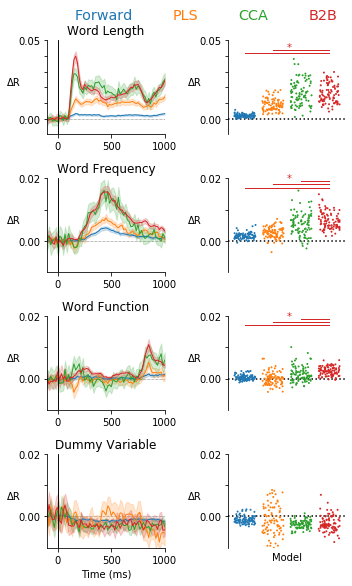

In [41]:
fig, axes = plt.subplots(4, 2, figsize=[5, 8])
for effect, (feature, ax) in enumerate(zip(features, axes)):

    for model_idx, model in enumerate(models):
        H_r, K_r = get_results(model)
        if not(len(H_r)):
            continue

        scores = H_r[:, :, effect] - K_r[:, :, effect]
        if model in ('B2B', 'B2B_ensemble', 'Backward'):
            scores = scores[:, :, [effect,]]
        scores = scores.mean(2)
        d = pd.DataFrame([dict(subject=subject, time=t, r=r)
                               for subject, score in enumerate(scores)
                               for t, r in zip(1e3*times, score)])
        sns.lineplot('time', 'r', data=d, color='C%i' % model_idx, 
                     lw=1., label=model, ax=ax[0], legend=False)

        ax[0].set_ylabel('ΔR').set_rotation(0)
        ax[0].axvline(0, color='k', lw=.5)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['top'].set_visible(False)
        ax[0].set_title(feature)
    
    ylim = np.around(ax[0].get_ylim()[1], 2)
    ylim = 0.02 if feature != 'Word Length' else 0.05
    ylim = max(ylim, .02)
    ax[0].set_yticks(np.arange(0, ylim+.001, .01))
    ax[0].set_ylim(-.01, ylim)
    ax[0].set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                           for f in np.arange(0, ylim+.001, .01)])
    ax[0].set_xlim(-100, 1000)
    ax[0].axhline(0, color='k', ls=':', zorder=-10, lw=.5)
    ax[0].set_xlabel('')
ax[0].set_xlabel('Time (ms)')

axes = iter(axes[:, 1])
for effect in features:
    d = data.query('effect==@effect')
    ax = next(axes)
    sns.stripplot(x='effect', y='r', hue='model', dodge=True, 
                  s=2, jitter=.3,
                  data=d, ax=ax)
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    ylim = np.around(ax.get_ylim()[1], 2)
    ylim = max(ylim, .02)
    ylim = 0.02 if effect != 'Word Length' else 0.05
    ax.set_ylim(-.01, ylim)
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else '' 
                        for f in np.arange(0, ylim+.001, .01)])
    ax.set_ylabel('ΔR').set_rotation(0)
    ax.set_xticks([])
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    
    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):

        r = list()
        _, p = wilcoxon(d.query('model == @m1').r.values)
        print('%s: %s: %.4f' % (effect, m1, p))
        
        for jdx, m2 in enumerate(models[:idx]):
            r = list()
            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append(subject.r.values)
            r1, r2 = np.transpose(r)
            u, p = wilcoxon(r1, r2)
            if m1 == 'B2B' and effect != 'dummy':
                print('%s: b2b versus %s: %.4f' % (effect, m2, p))
            if p < .05 and m1 == 'B2B' and np.median(r1) < np.median(r2):
                k += 1
                y = .8 * ylim + k * space
                if np.median(r1) < np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                ax.plot(np.linspace(-.3, .3, 4)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)
    if effect != 'Dummy Variable':
        ax.text(0, y, '*', color='C3')
ax.set_xlabel('Model')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(4)]
lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, ['',] + models, loc='upper center', 
                    ncol=5, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False,
                    bbox_to_anchor=(0.5,1.025))

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

fig.tight_layout()
#fig.savefig('meg.pdf', bbox_extra_artists=(leg,), bbox_inches='tight')

/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl
/private/home/jeanremi/data/mous/raw/../jrr/1035-CCA.pkl


<Figure size 576x576 with 0 Axes>

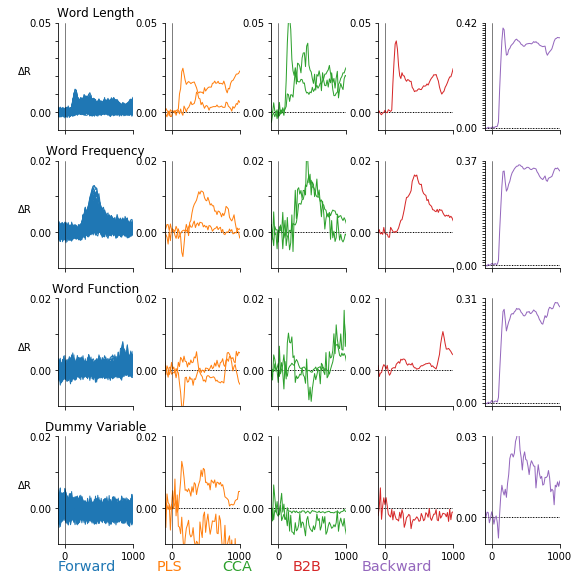

In [44]:
models = [
          'Forward',
          'PLS',
          'CCA',
          'B2B', 
          'Backward', 
]
fig = plt.figure(figsize=[8, 8])
fig, axes = plt.subplots(4, 5, figsize=[8, 8], sharex=True)
for effect, (feature, axs) in enumerate(zip(features, axes)):

    for model_idx, (model, ax) in enumerate(zip(models, axs)):
        
        #ax = axs[model_idx]
        H_r, K_r = get_results(model)
        if not(len(H_r)):
            continue

        scores = H_r[:, :, effect] - K_r[:, :, effect]
        if model in ('B2B', 'B2B_ensemble', 'Backward'):
            scores = scores[:, :, [effect,]]
        scores = scores.mean(0)
        
        ax.plot(times*1e3, scores, color='C%i' % model_idx, 
                lw=1.)

        ax.set_ylabel('ΔR').set_rotation(0)
        ax.axvline(0, color='k', lw=.5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if model_idx == 0:
            ax.set_title(feature)
        if model_idx != 0:
            ax.set_yticklabels([])
            ax.set_ylabel('')
        ax.axhline(0, color='k', lw=1, zorder=-1, ls=':')
        
        ax.set_xlim(-100, 1000)
        if feature == 'Word Length' and model != 'Backward':
            ax.set_ylim(-.01, .05)
        elif model != 'Backward':
            ax.set_ylim(-.01, .02)
    
        ylim = np.around(ax.get_ylim()[1], 2)
        ax.set_yticks(np.arange(0, ylim+.001, .01))
        ax.set_ylim(-.01, ylim)
        ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                               for f in np.arange(0, ylim+.001, .01)])
        ax.set_xlim(-100, 1000)
        ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
        ax.set_xlabel('')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(5)]
lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, ['',] + models, loc=(0, -0), 
                    ncol=6, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False)

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    
fig.tight_layout(w_pad=-1)
fig.savefig('meg_supp.pdf')

/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd764fb1f28>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd76c4bcbe0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/private/home/jeanremi/.conda/envs/mous/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fd76c4bcef0>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating

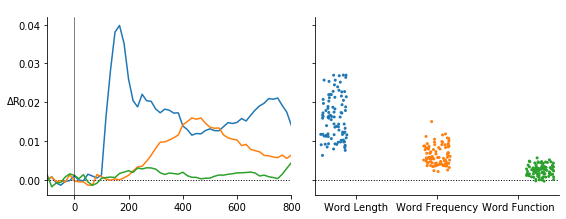

In [171]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=[8, 3],sharey=True)
H_r, K_r = get_results('B2B')

lines = list()
for effect in range(3):
    scores = H_r[:, :, effect] - K_r[:, :, effect]
    scores = scores[:, :, [effect,]]
    scores = scores.mean(0)

    lines.append(ax.plot(times*1e3, scores))

ax.set_ylabel('ΔR').set_rotation(0)
ax.axvline(0, color='k', lw=.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(0, color='k', lw=1, zorder=-1, ls=':')
ax.set_xlim(-100, 800)


sns.stripplot(x='effect', y='r', hue='effect', dodge=True, 
              s=3, jitter=.5,
              data=data.query('model=="B2B" and effect != "Dummy Variable"'), ax=ax2)
ax2.axhline(0, color='k', lw=1, zorder=-1, ls=':')
ax2.set_xlabel('')
ax2.set_xlim(-.5, 2.5)
ax2.legend().set_visible(False)
ax2.set_ylabel('').set_rotation(0)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

leg = plt.figlegend(lines, features[:3], loc='upper center', 
                    ncol=3, labelspacing=0.,
                    handlelength=0, frameon=False,
                    bbox_to_anchor=(0.5,1.025))
for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

fig.tight_layout()

In [170]:
%retina

UsageError: Line magic function `%retina` not found.


In [172]:
fig.savefig('three_effects.png', dpi=150)

# Plot evoked

In [3]:
def get_evoked(subject):
    log_file = log_files.iloc[subject]
    # file name
    raw_fname = op.join(data_path, log_file['meg_file'])
    log_fname = op.join(data_path, log_file['log_file'])

    # preprocess meg data
    raw = mne.io.read_raw_ctf(raw_fname, preload=True, verbose=False)
    raw.filter(.1, 40., verbose=False)
    events = mne.find_events(raw, verbose=False)

    # preprocess annotations
    log = read_log(log_fname)

    # link meg and annotations
    log = get_log_times(log, events,  raw.info['sfreq'])

    # Segment into word-locked epochs
    log_events = np.c_[log.meg_sample, np.ones((len(log), 2), int)]
    _, idx = np.unique(log_events[:, 0], return_index=True)
    picks = mne.pick_types(raw.info, meg=True, eeg=False,
                           stim=False, eog=False, ecg=False)
    epochs = mne.Epochs(
        raw,
        events=log_events[idx], metadata=log.iloc[idx],
        tmin=-.100, tmax=1., decim=20,
        picks=picks, preload=True,
        verbose=False
    )
    epochs = epochs['condition=="word"']
    meg = np.median(epochs.get_data(), axis=0)
    
    evo = mne.EvokedArray(meg, epochs.info, tmin=-.100)
    evo = remap(evo)
    
    return evo

In [5]:
def remap(evo):
    from mne import EvokedArray
    from mne.datasets import sample, spm_face
    from mne.channels.interpolation import _map_meg_channels
    from mne import io

    # CTF
    evoked_ctf = evo

    # Elekta
    data_path = sample.data_path() + '/MEG/sample/sample_audvis_filt-0-40_raw'
    raw = mne.io.read_raw_fif(data_path + '.fif')
    events = mne.read_events(data_path + '-eve.fif')
    epochs_elk = mne.Epochs(raw, events, {'AudL': 1, 'AudR': 2}, -0.050, 0.400,
                            preload=True, decim=2, verbose=False)
    epochs_elk.pick_types(meg=True, eeg=False, exclude=list())
    evoked_elk = epochs_elk.average()

    # Map
    mapping = _map_meg_channels(evoked_ctf.info, evoked_elk.info, mode='accurate')
    new = mapping.dot(evoked_ctf.data)
    evoked_new = EvokedArray(new, evoked_elk.info, evoked_ctf.times[0])
    return evoked_new

In [6]:
evoked = get_evoked(0)

<ipython-input-4-86f990841730>:28: RuntimeWarning: The measurement information indicates a low-pass frequency of 40 Hz. The decim=20 parameter will result in a sampling frequency of 60 Hz, which can cause aliasing artifacts.
  verbose=False


Opening raw data file /private/home/jeanremi/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0


<ipython-input-5-6753b31c7637>:15: RuntimeWarning: The measurement information indicates a low-pass frequency of 40 Hz. The decim=2 parameter will result in a sampling frequency of 75.0769 Hz, which can cause aliasing artifacts.
  preload=True, decim=2, verbose=False)


    Computing dot products for 301 coils...
    Computing cross products for coils 301 x 306 coils...
    Preparing the mapping matrix...
    Truncating at 69/301 components to omit less than 0.0001 (9.8e-05)


In [25]:
log_path = op.join(data_path, '..', 'jrr', 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=10, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', 
                           cpus_per_task=4)

jobs = list()
folder = 'jrr'
for subject in trange(len(log_files)):
    jobs.append([subject,])
jobs = executor.map_array(get_evoked, *zip(*jobs))

100%|██████████| 100/100 [00:00<00:00, 287084.46it/s]


In [29]:
# retrieve results
all_evo = list()
for job in jobs:
    print('*', end='')
    try:
        evo = job.result()
        all_evo.append(evo.data)
    except:
        pass
evoked = mne.EvokedArray(np.mean(all_evo, 0), evo.info,  tmin=evo.times[0])

****************************************************************************************************

In [66]:
evoked = mne.EvokedArray(np.mean(all_evo, 0), evo.info,  tmin=evo.times[0])

In [76]:
evoked.nave = len(all_evo)

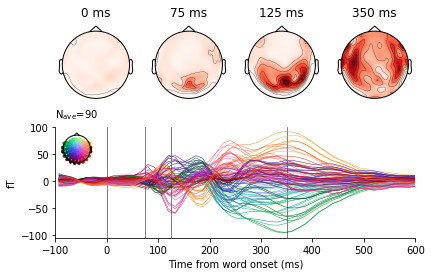

In [86]:
fig = plt.figure()
axes = [fig.add_subplot(2, 4 , idx+1) for idx in range(4)]
ax = fig.add_subplot(2, 1 , 2)

tois = [0., .075, .125, .350]
evoked.plot_topomap(times=tois,
                   ch_type='grad', sensors=False, axes=axes,
                   colorbar=False, show=False, time_unit='ms');
evoked.plot(spatial_colors=True, 
            picks=mne.pick_types(evoked.info, 'mag'), axes=[ax],
            show=False, time_unit='ms', window_title=False);
for t in tois:
    ax.axvline(t*1e3, color='k', lw=.5)
ax.set_title('')
ax.set_xlim(-100, 600)
ax.set_xlabel('Time from word onset (ms)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('meg_evoked.pdf')

In [104]:
from scipy.stats import pearsonr
r = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        r[i, j], _ = pearsonr(features[:,i], features[:,j])

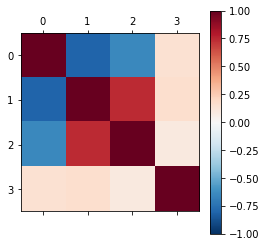

In [109]:
plt.matshow(r, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()